In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy import stats
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from scipy.stats import ttest_ind

In [125]:
data = pd.read_csv('Employee_Attrition_Data_Set.csv')  #todo:数据集地址

In [126]:
data.head()

,Employee ID,Age,Gender,Job Role,Department,Monthly Income,Years at Company,Number of Promotions,Last Raise Percentage,Distance from Office,Job Satisfaction,Performance Rating,Attrition
0,1,50,Male,HR,IT,11547,12,1,12.288783,41.307654,9,1,No
1,2,36,Male,Sales,Support,8643,28,4,3.496371,44.733204,8,1,Yes
2,3,29,Male,Technician,HR,12418,12,4,4.796945,18.646876,1,3,No
3,4,42,Male,Technician,Support,11441,25,1,10.310471,15.790848,8,4,No
4,5,40,Female,Engineer,Sales,9178,25,2,6.210127,41.239179,6,4,No


In [127]:
data.describe()

,Employee ID,Age,Monthly Income,Years at Company,Number of Promotions,Last Raise Percentage,Distance from Office,Job Satisfaction,Performance Rating
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,40.561200,8948.750300,14.311100,1.958300,10.022797,26.632481,5.407000,2.992900
std,2886.89568,10.876483,3473.354793,8.742572,1.426171,5.823696,14.396393,2.943504,1.410833
min,1.00000,22.000000,3000.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2500.75000,31.000000,5895.000000,7.000000,1.000000,5.101189,14.509275,3.000000,2.000000
50%,5000.50000,41.000000,8982.500000,14.000000,2.000000,9.990978,27.122930,5.000000,3.000000
75%,7500.25000,50.000000,11928.250000,22.000000,3.000000,15.042273,39.148606,8.000000,4.000000
max,10000.00000,59.000000,14999.000000,30.000000,5.000000,20.000000,50.000000,10.000000,5.000000


In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Employee ID            10000 non-null  int64  
 1   Age                    10000 non-null  int64  
 2   Gender                 9987 non-null   object 
 3   Job Role               10000 non-null  object 
 4   Department             10000 non-null  object 
 5   Monthly Income         10000 non-null  int64  
 6   Years at Company       10000 non-null  int64  
 7   Number of Promotions   10000 non-null  int64  
 8   Last Raise Percentage  10000 non-null  float64
 9   Distance from Office   10000 non-null  float64
 10  Job Satisfaction       10000 non-null  int64  
 11  Performance Rating     10000 non-null  int64  
 12  Attrition              10000 non-null  object 
dtypes: float64(2), int64(7), object(4)
memory usage: 1015.8+ KB


In [129]:
# Search for all attributes that may be dates
date_columns = [col for col in data.columns if data[col].astype(str).str.contains(r'\b\d{4}[-/]\d{2}[-/]\d{2}\b', na=False).any()]
# Convert date-formatted columns to datetime types
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')
# Print the converted data type
#todo:删除上面所有然后写data['A']=pd.to_datetime(data['A']) 或者删除这个todo
print(data.dtypes)

Employee ID                int64
Age                        int64
Gender                    object
Job Role                  object
Department                object
Monthly Income             int64
Years at Company           int64
Number of Promotions       int64
Last Raise Percentage    float64
Distance from Office     float64
Job Satisfaction           int64
Performance Rating         int64
Attrition                 object
dtype: object


In [130]:
data.isnull().sum()

Employee ID               0
Age                       0
Gender                   13
Job Role                  0
Department                0
Monthly Income            0
Years at Company          0
Number of Promotions      0
Last Raise Percentage     0
Distance from Office      0
Job Satisfaction          0
Performance Rating        0
Attrition                 0
dtype: int64

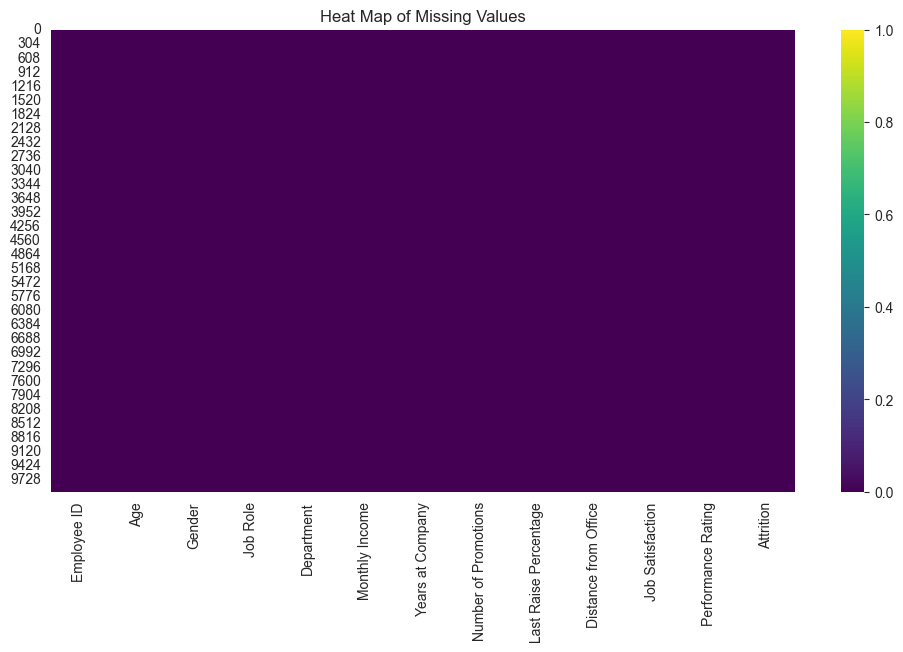

In [131]:
# Create a figure for the heatmap
plt.figure(figsize=(12, 6))
# Plot a heatmap to visualize missing values in the dataset
sns.heatmap(data.isnull(), cbar=True, cmap='viridis')
# Set the title for the heatmap
plt.title('Heat Map of Missing Values')
# Display the plot
plt.show()

In [132]:
# Check the percentage of missing values in each column
missing_ratio = data.isnull().mean()
# Delete columns with more than 50% missing values
cols_to_drop = missing_ratio[missing_ratio > 0.5].index
data.drop(columns=cols_to_drop, inplace=True)
data.drop(columns=['Employee ID'], inplace=True)  #todo:删除员工ID等无意义的属性 columns=['A','B',....]

In [133]:
# Fill in missing values
for column in data.columns:
    if data[column].dtype == 'object':  # For string columns
        data[column].fillna(data[column].mode()[0], inplace=True)
    elif np.issubdtype(data[column].dtype, np.number):  # For numeric columns
        data[column].fillna(data[column].mean(), inplace=True)
    elif np.issubdtype(data[column].dtype, np.datetime64):  # For the time column
        data[column].fillna(data[column].median(), inplace=True)

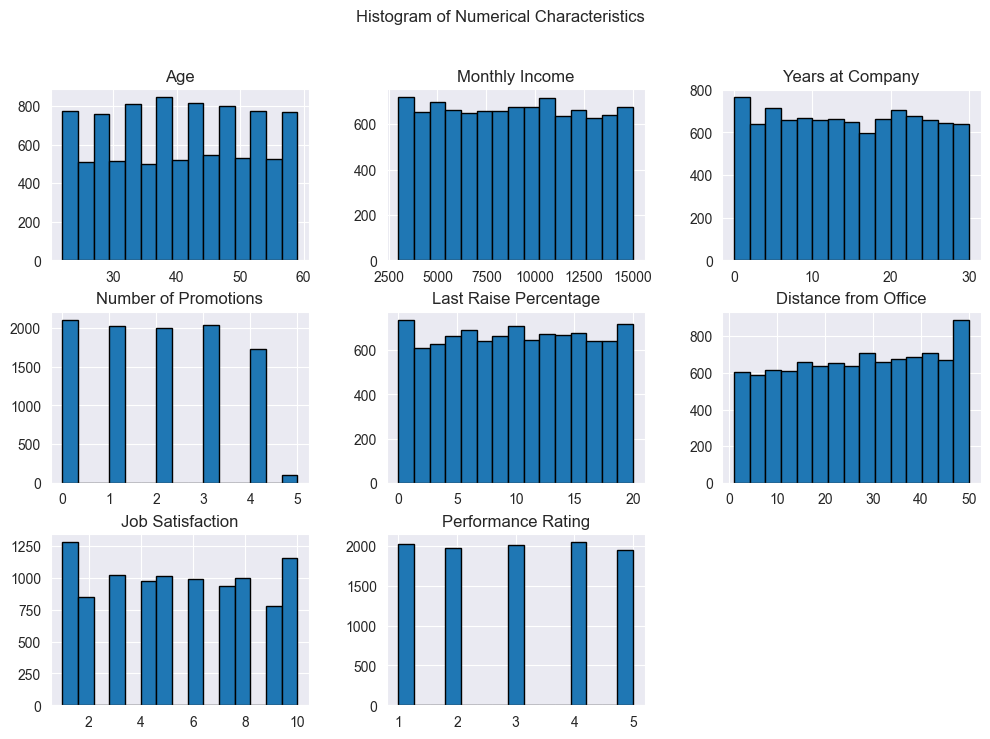

In [134]:
# Select numerical columns from the data
num_features = data.select_dtypes(include=[np.number]).columns
# Plot histograms for each numerical feature
data[num_features].hist(figsize=(12, 8), bins=15, edgecolor='black')
# Set the overall title for the plot
plt.suptitle('Histogram of Numerical Characteristics')
# Display the plot
plt.show()


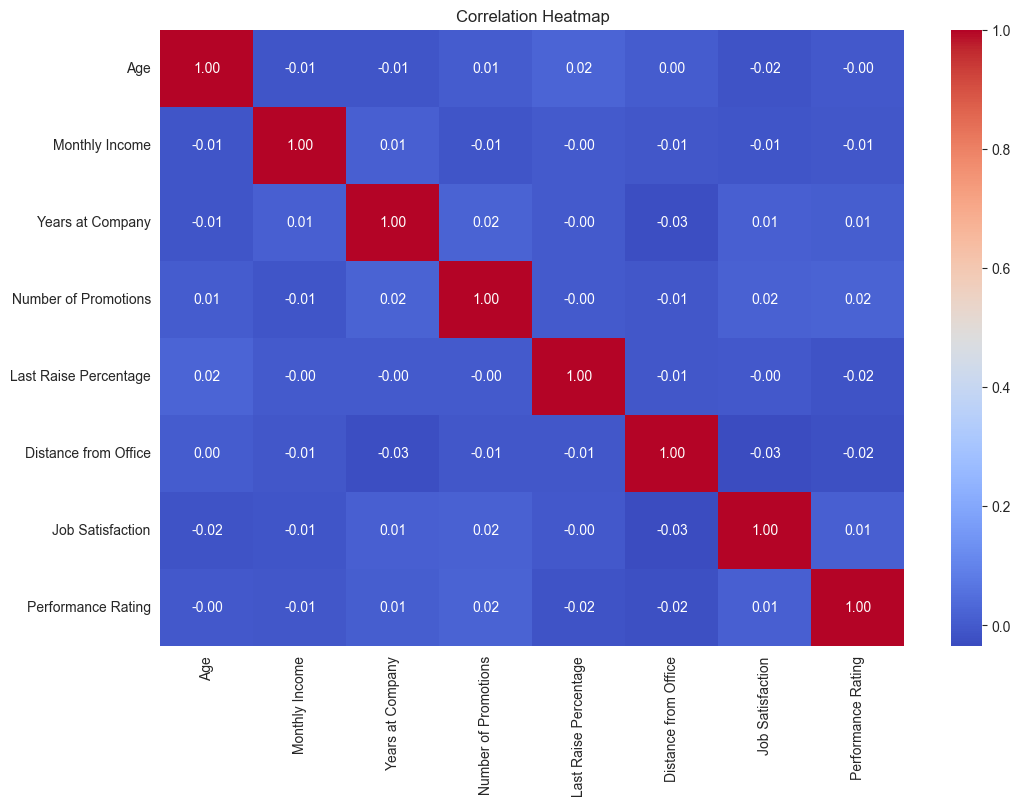

In [135]:
# Select numerical columns from the data
num_features = data.select_dtypes(include=[np.number])
# Calculate the correlation matrix for numerical features
correlation = num_features.corr()
# Create a figure for the heatmap
plt.figure(figsize=(12, 8))
# Plot the correlation matrix as a heatmap
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')
# Set the title for the heatmap
plt.title('Correlation Heatmap')
# Display the plot
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_31216\1077391782.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data[col], palette='viridis')
C:\Users\DELL\AppData\Local\Temp\ipykernel_31216\1077391782.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data[col], palette='viridis')
C:\Users\DELL\AppData\Local\Temp\ipykernel_31216\1077391782.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data[col], palette='viridis')
C:\Users\DELL\AppData\Local\Temp\ipykernel_31216\1077391782.py:10: FutureWarning: 

Passing `palette` with

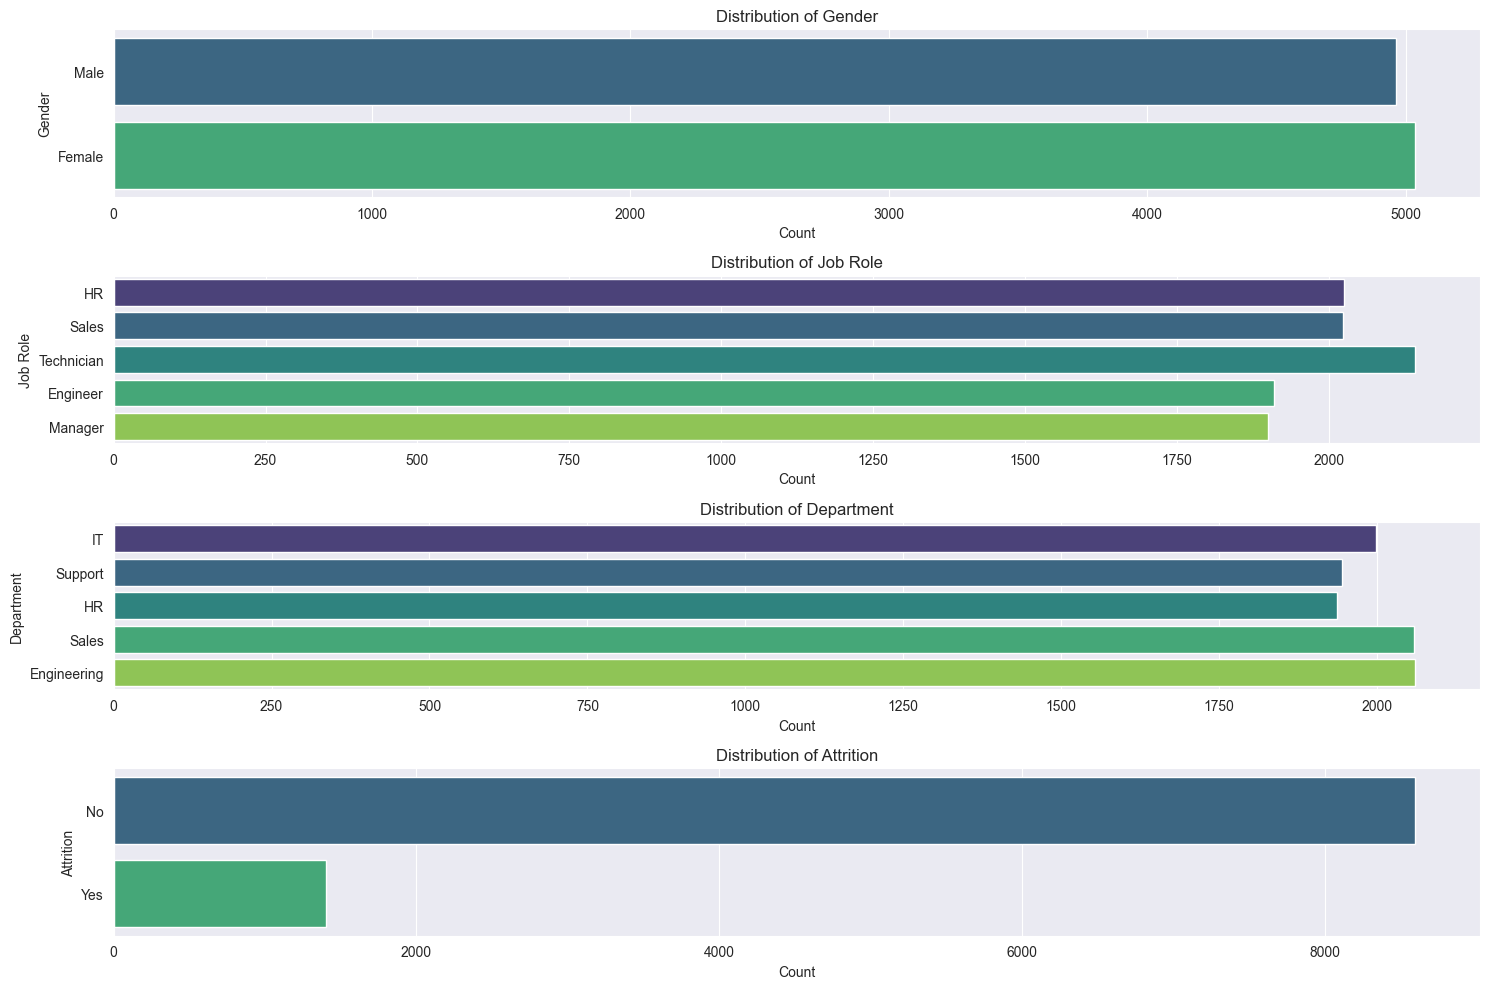

In [136]:
# Plotting distributions of non-numeric (categorical) attributes
object_columns = data.select_dtypes(include=['object']).columns
# Create a figure for the plots
plt.figure(figsize=(15, 10))
# Iterate over the categorical columns and create a subplot for each
for i, col in enumerate(object_columns):
    # Create a subplot for the current column
    plt.subplot(len(object_columns), 1, i + 1)
    # Plot the count distribution of the current column
    sns.countplot(y=data[col], palette='viridis')
    # Set the title and labels for the subplot
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
# Adjust layout to prevent overlap
plt.tight_layout()
# Display the plot
plt.show()


<Axes: ylabel='Monthly Income'>

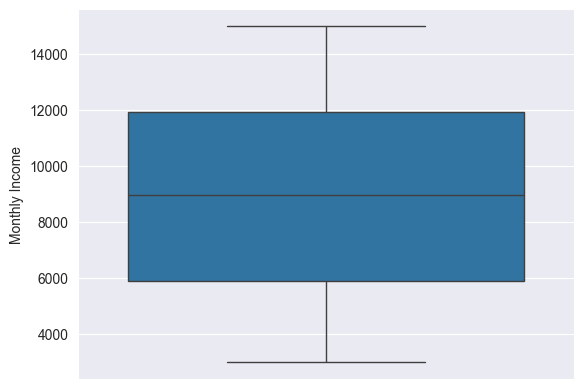

In [137]:
sns.boxplot(data['Monthly Income'])  #todo:数值

<Axes: xlabel='Department'>

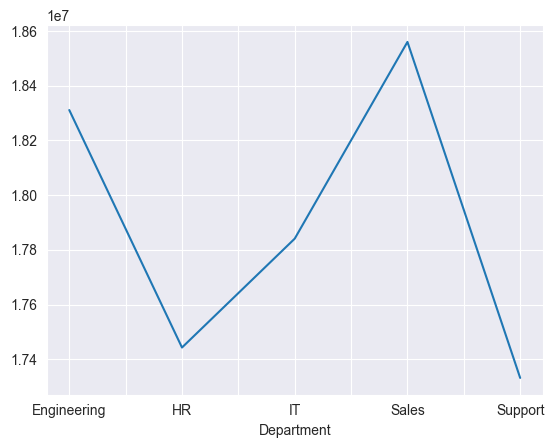

In [138]:
data.groupby('Department')['Monthly Income'].sum().sort_index().plot()  #todo:标签，数值

<Axes: xlabel='Job Role'>

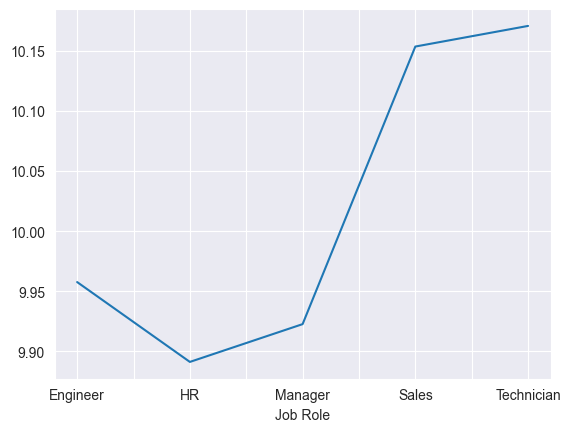

In [139]:
data.groupby('Job Role')['Last Raise Percentage'].mean().sort_index().plot()  #todo:标签，数值

<Axes: xlabel='Attrition', ylabel='Monthly Income'>

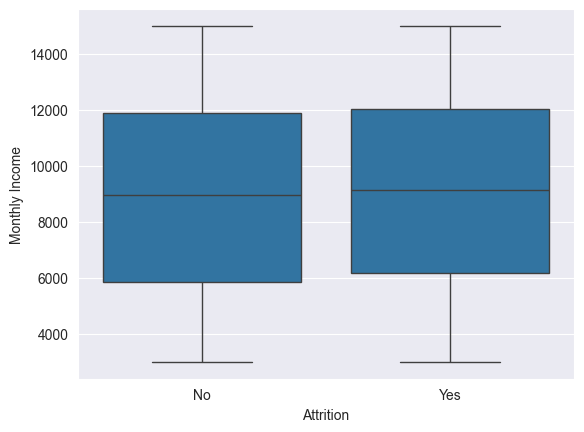

In [140]:
sns.boxplot(x='Attrition', y='Monthly Income', data=data)  #todo:目标变量，数值

(array([ 897.,  909.,  930.,  977.,  974., 1024.,  985., 1037., 1034.,
        1233.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <BarContainer object of 10 artists>)

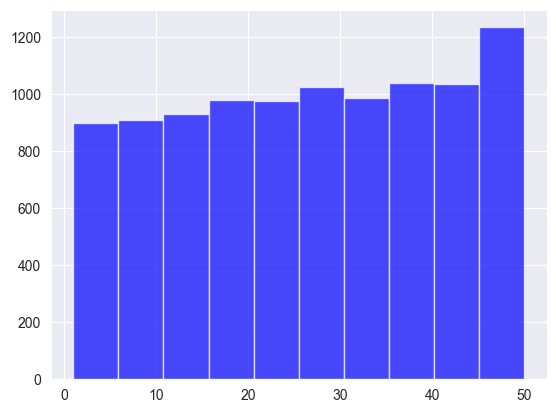

In [141]:
plt.hist(data['Distance from Office'], alpha=0.7, color='blue')  #todo:数值

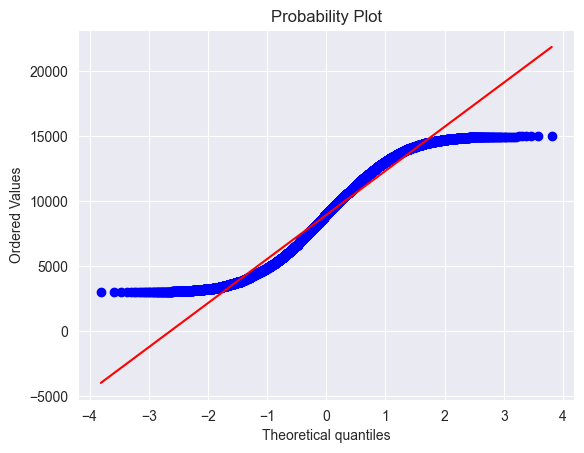

Skewness: 0.01156360651605939
Kurtosis: -1.1949077595644753


In [142]:
column = 'Monthly Income'  #todo:数值
# Generate a Q-Q plot to assess if the data follows a normal distribution
stats.probplot(data[column], dist='norm', plot=plt)
# Display the plot
plt.show()
# Calculate and print the skewness of the data Skewness indicates the asymmetry of the data distribution
print("Skewness:", stats.skew(data[column]))
# Calculate and print the kurtosis of the data Kurtosis indicates the 'tailedness' of the data distribution fisher=True adjusts the result to match the Fisher definition (normal distribution kurtosis = 0)
print("Kurtosis:", stats.kurtosis(data[column], fisher=True))

((array([6.93147181e-05, 1.68258014e-04, 2.68276192e-04, ...,
         8.22362768e+00, 8.69009609e+00, 9.57688795e+00]),
  array([ 3000,  3002,  3003, ..., 14992, 14997, 14999], dtype=int64)),
 (3021.1999958604983, 5928.144771446716, 0.8687915036551894))

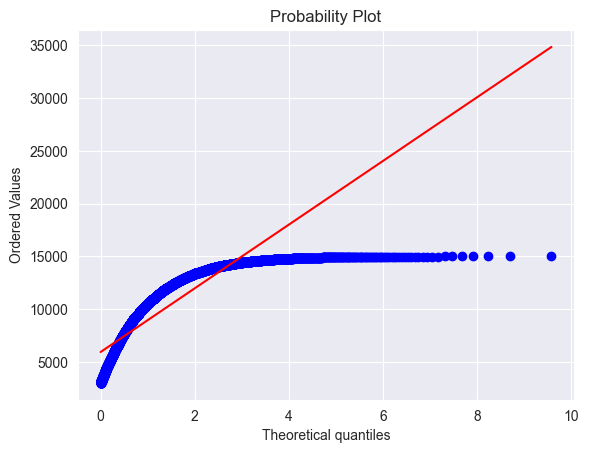

In [143]:
column = 'Monthly Income'  #todo:数值
stats.probplot(data[column], dist='expon', plot=plt)

<Axes: xlabel='Job Role'>

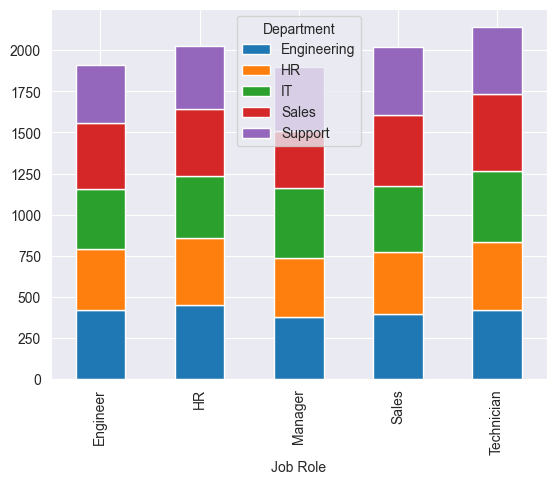

In [144]:
data.groupby(['Job Role', 'Department'])['Age'].count().unstack().plot(kind='bar', stacked=True)  #todo:标签，标签，数值

C:\Users\DELL\AppData\Local\Temp\ipykernel_31216\2774019296.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Department', y='Monthly Income', data=data, ax=ax1, palette='tab10')  #todo:标签A，数值B
C:\Users\DELL\AppData\Local\Temp\ipykernel_31216\2774019296.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Department', y='Years at Company', data=data, ax=ax2, palette='tab10')  #todo:标签A，数值C
C:\Users\DELL\AppData\Local\Temp\ipykernel_31216\2774019296.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Department', y='Number of Promot

<Axes: xlabel='Department', ylabel='Number of Promotions'>

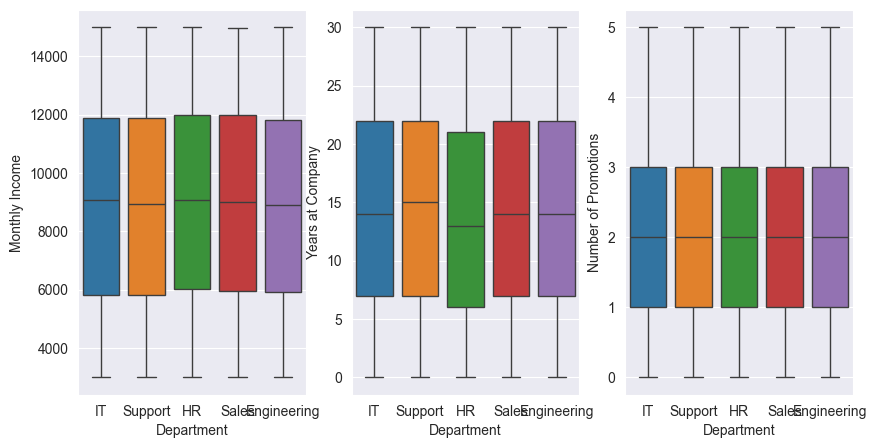

In [145]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
sns.boxplot(x='Department', y='Monthly Income', data=data, ax=ax1, palette='tab10')  #todo:标签A，数值B
sns.boxplot(x='Department', y='Years at Company', data=data, ax=ax2, palette='tab10')  #todo:标签A，数值C
sns.boxplot(x='Department', y='Number of Promotions', data=data, ax=ax3, palette='tab10')  #todo:标签A，数值D

<Axes: xlabel='Job Role', ylabel='Job Satisfaction'>

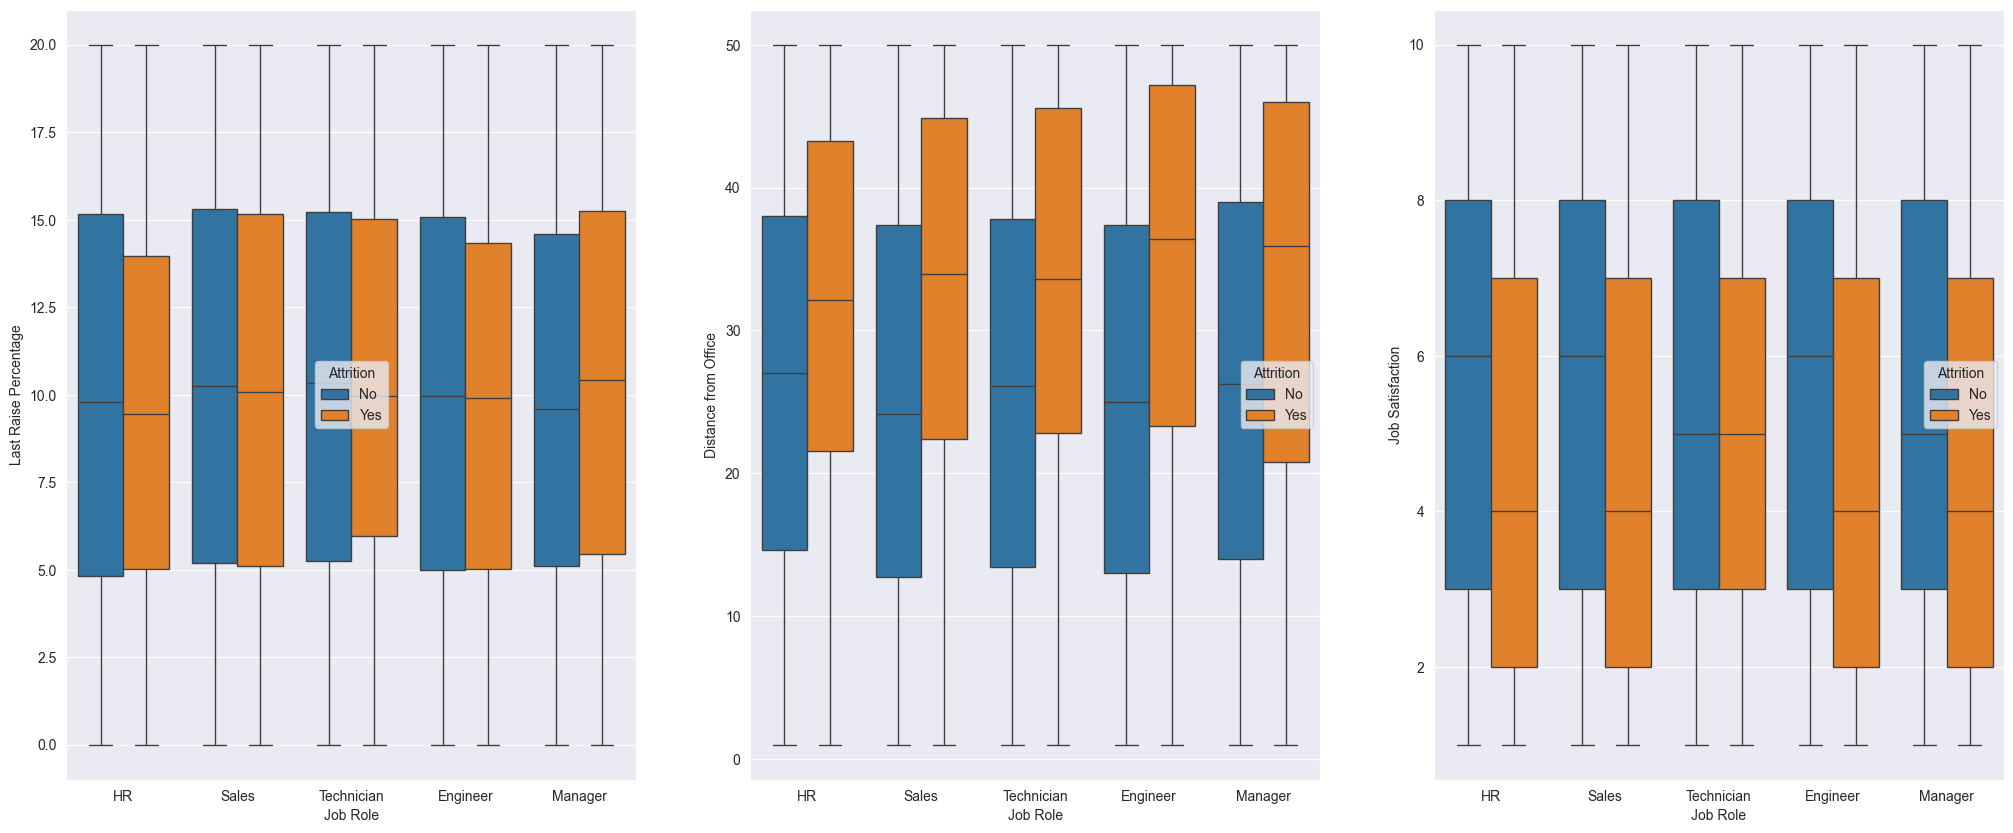

In [146]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))
sns.boxplot(x='Job Role', y='Last Raise Percentage', hue='Attrition', data=data, ax=ax1, palette='tab10')  #todo:标签A，数值B，目标变量
sns.boxplot(x='Job Role', y='Distance from Office', hue='Attrition', data=data, ax=ax2, palette='tab10')  #todo:标签A，数值C，目标变量
sns.boxplot(x='Job Role', y='Job Satisfaction', hue='Attrition', data=data, ax=ax3, palette='tab10')  #todo:标签A，数值D，目标变量

In [147]:
left_employees = data[data['Attrition'] == 'Yes']  #todo:目标变量 ，目标变量取值1(在这里Attrition取值不是Yes就是No)
stayed_employees = data[data['Attrition'] == 'No']  #todo:目标变量， 目标变量取值2
numerical_cols = data.select_dtypes(include='number').columns
ttest_results = {}
for col in numerical_cols:
    t_stat, p_value = ttest_ind(left_employees[col], stayed_employees[col], nan_policy='omit')
    ttest_results[col] = {'t_stat': t_stat, 'p_value': p_value}
# Convert results to DataFrame for better readability
ttest_results_df = pd.DataFrame(ttest_results).T
ttest_results_df

,t_stat,p_value
Age,1.267150,2.051311e-01
Monthly Income,1.758007,7.877691e-02
Years at Company,-5.754653,8.937397e-09
Number of Promotions,-6.321402,2.702641e-10
Last Raise Percentage,-0.176573,8.598472e-01
Distance from Office,16.633428,2.649878e-61
Job Satisfaction,-9.026077,2.107206e-19
Performance Rating,-7.408740,1.378174e-13


In [148]:
X, y = data.drop(columns=['Attrition']), data['Attrition']  #todo:目标变量
y = y.map({'Yes': 1, 'No': 0})  #todo:把标签换成数值
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [149]:
# Select columns with categorical data
categorical_features = X.select_dtypes(include=['object']).columns

# Define a pipeline for transforming categorical features
categorical_transformer = Pipeline(steps=[
    # Apply one-hot encoding to handle categorical features
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [150]:
# Select columns with numerical data
numerical_features = X.select_dtypes(include=['number']).columns
# Define a pipeline for transforming numerical features
numerical_transformer = Pipeline(steps=[
    # Apply standard scaling to normalize numerical features
    ('scaler', StandardScaler())
])


In [151]:
# Combine numerical and categorical transformers into a single preprocessor
preprocessor = ColumnTransformer(transformers=[
    # Apply the numerical transformer to numerical features
    ('num', numerical_transformer, numerical_features),
    # Apply the categorical transformer to categorical features
    ('cat', categorical_transformer, categorical_features)
])

In [152]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['liblinear']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_features': ['sqrt', 'log2'],
            'classifier__max_depth': [None, 10, 20, 30]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'Support Vector Machine': {  #todo:支持向量机很费时间，时间不够可以把这个扔掉
        'model': SVC(probability=True),
        'params': {  #todo:也可以删掉一些组合，一共三行参数，只要有一行参数数量大于2就行,[0.1, 1, 10, 100]是四个参数
            'classifier__C': [0.1, 1, 10, 100],
            # 'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            # 'classifier__gamma': ['scale', 'auto']
        }
    }
}

In [153]:
# Initialize a dictionary to store the best models
best_models = {}
# Define a list of evaluation metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']
# Initialize a dictionary to store the results for each metric
results = {metric: [] for metric in metrics}
# Initialize a list to store the names of the models
model_names = []

In [154]:
for name, model_params in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model_params['model'])])
    param_grid = model_params['params']
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='f1')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    y_pred = grid_search.predict(X_test)
    # Store the model name
    model_names.append(name)
    # Calculate and store indicators
    results['accuracy'].append(accuracy_score(y_test, y_pred))
    results['precision'].append(precision_score(y_test, y_pred, average='macro'))
    results['recall'].append(recall_score(y_test, y_pred, average='macro'))
    results['f1'].append(f1_score(y_test, y_pred, average='macro'))
    print(f'Best parameters for {name}: {grid_search.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters for KNN: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Naive Bayes: {'classifier__var_smoothing': 1e-09}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Random Forest: {'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 50}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Be

In [155]:
df = pd.DataFrame(results, index=model_names)  #todo:数据可以搞到report表格里
df

,accuracy,precision,recall,f1
Logistic Regression,0.855667,0.427976,0.499805,0.461110
KNN,0.837333,0.533230,0.508351,0.493288
Naive Bayes,0.854000,0.427856,0.498832,0.460626
Random Forest,0.852667,0.625578,0.515382,0.497635
Decision Tree,0.782000,0.530024,0.526090,0.527365
Support Vector Machine,0.770667,0.517916,0.516582,0.517049


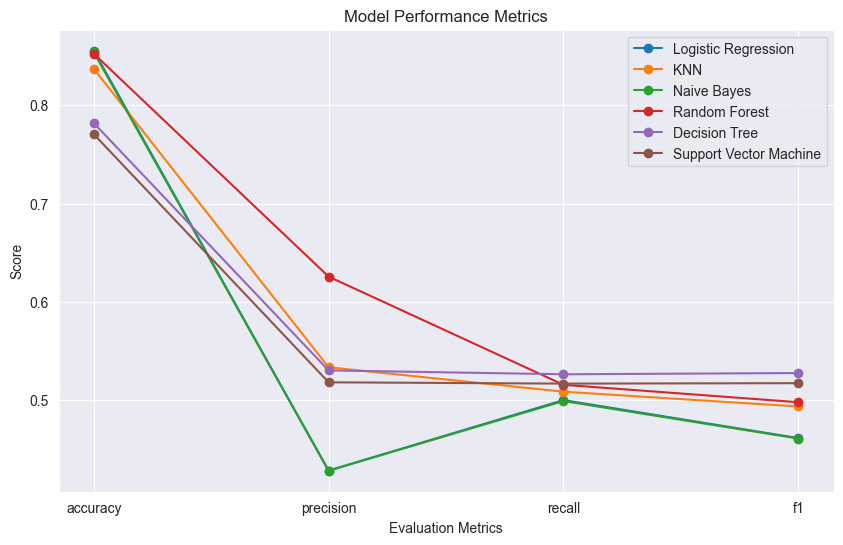

In [156]:
# Convert the results dictionary to a DataFrame
results_data = pd.DataFrame(results, index=model_names)
# Transpose the DataFrame so that models are columns and metrics are rows
results_data_transposed = results_data.T
# Plot results
plt.figure(figsize=(10, 6))
for model in results_data_transposed.columns:
    plt.plot(results_data_transposed.index, results_data_transposed[model], marker='o', label=model)
plt.xlabel('Evaluation Metrics')
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()

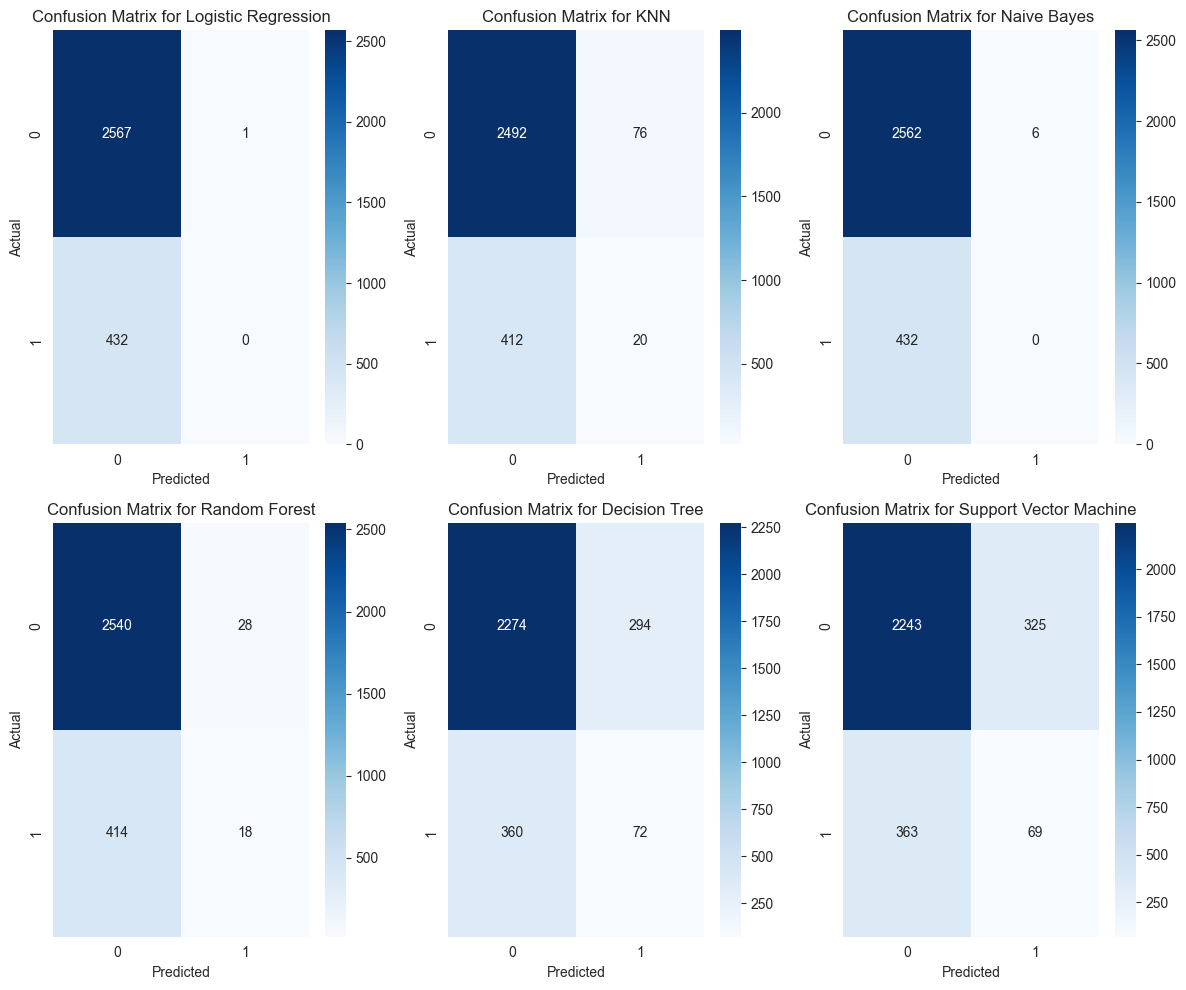

In [157]:
# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 10))  #todo:六个模型就2*3，四个模型就2*2
# Flatten the axes array for easy iteration
axes = axes.flatten()
# Iterate over the axes and the best models
for ax, (name, model) in zip(axes, best_models.items()):
    # Predict the target values using the model
    y_pred = model.predict(X_test)
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    # Set the title and labels for the subplot
    ax.set_title(f'Confusion Matrix for {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
# Adjust layout to prevent overlap
plt.tight_layout()
# Display the plot
plt.show()


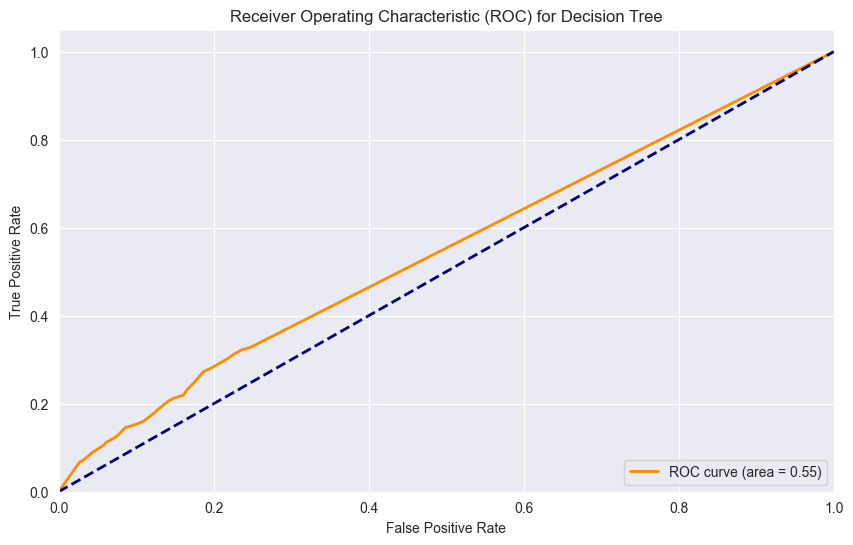

The best model is: Decision Tree with an AUC of 0.55


In [158]:
best_model_index = results['f1'].index(max(results['f1']))
best_model_name = model_names[best_model_index]
best_model = best_models[best_model_name]
# Predicted probability
y_prob = best_model.predict_proba(X_test)[:, 1]
# Calculate ROC curves and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
# Plotting ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) for {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print(f'The best model is: {best_model_name} with an AUC of {roc_auc:.2f}')
